<a href="https://colab.research.google.com/github/rich-hyun/6th-statistic-competition/blob/main/Statistic_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#데이터 정리

In [ ]:
import pandas as pd
import numpy as np

# 1) 데이터 로드 & 전처리
df = pd.read_csv("competition.csv").rename(columns={"Unnamed: 0": "Year"})
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df = df.sort_values("Year")

num_cols = [
    "연금보험료 (단위:억원)","연금급여지급 (단위:억원)","관리운영비 등 (단위:억원)",
    "국고보조금 등 (단위:억원)","연도별 기금 운용 수익률","국민연금 기금 적립 규모(단위: 조원)"
]
for c in num_cols:
    df[c] = pd.to_numeric(df[c].astype(str).str.replace(",","").str.strip(), errors="coerce")

# 2) 2024년 기준치
base = df[df["Year"]==2024].iloc[0]
fund = base["국민연금 기금 적립 규모(단위: 조원)"] * 10000  # 조원→억원
contrib, benefit, admin, subsidy = (
    base["연금보험료 (단위:억원)"],
    base["연금급여지급 (단위:억원)"],
    base["관리운영비 등 (단위:억원)"],
    base["국고보조금 등 (단위:억원)"],
)

# 3) 최근 10년 CAGR과 수익률
last10 = df[df["Year"] >= df["Year"].max()-9]
def cagr(s):
    s = s.dropna()
    if len(s)<2: return 0.0
    a,b,n = s.iloc[0], s.iloc[-1], len(s)-1
    if a<=0 or b<=0: return 0.0
    return (b/a)**(1/n)-1

g_contrib = cagr(last10["연금보험료 (단위:억원)"])
g_benefit = cagr(last10["연금급여지급 (단위:억원)"])
g_admin   = cagr(last10["관리운영비 등 (단위:억원)"])
g_subsidy = cagr(last10["국고보조금 등 (단위:억원)"])
r = (np.prod(1+last10["연도별 기금 운용 수익률"].dropna()/100)**(1/max(1,len(last10.dropna()))) - 1) or 0.04

# 4) 전망 생성(2025~), 고갈까지
rows=[]
for year in range(2025, 2101):
    if year>2025:
        contrib *= (1+g_contrib)
        benefit *= (1+g_benefit)
        admin   *= (1+g_admin)
        subsidy *= (1+g_subsidy)

    invest_income = fund * r                          # 전기말 잔액에만 수익 반영(보수적)
    net_cash = contrib + subsidy - (benefit + admin)  # 현금수지
    fund = fund + invest_income + net_cash            # 기금 갱신

    rows.append([year, contrib+subsidy, benefit+admin, invest_income, fund])
    if fund <= 0:
        break

result = pd.DataFrame(rows, columns=["연도","예상수입(억원)","예상지출(억원)","예상운용수익(억원)","연도말 잔여 기금(억원)"])
result_2026_on = result[result["연도"]>=2026].copy()

# 확인용 출력
print("예상 고갈 연도:", result.loc[result["연도말 잔여 기금(억원)"]<=0, "연도"].min())
print(result_2026_on.head(), "\n", result_2026_on.tail())


예상 고갈 연도: 2053
     연도       예상수입(억원)       예상지출(억원)    예상운용수익(억원)  연도말 잔여 기금(억원)
1  2026  656193.348433  500219.096447  8.592082e+05   1.411327e+07
2  2027  695807.001733  561859.895749  9.258021e+05   1.517302e+07
3  2028  737812.112929  631153.442158  9.953195e+05   1.627500e+07
4  2029  782353.054704  709052.306461  1.067607e+06   1.741591e+07
5  2030  829582.915624  796627.737114  1.142448e+06   1.859131e+07 
       연도      예상수입(억원)      예상지출(억원)    예상운용수익(억원)  연도말 잔여 기금(억원)
24  2049  2.526655e+06  7.349649e+06  1.674176e+06   2.237294e+07
25  2050  2.679189e+06  8.263884e+06  1.467620e+06   1.825587e+07
26  2051  2.840930e+06  9.291995e+06  1.197548e+06   1.300235e+07
27  2052  3.012437e+06  1.044817e+07  8.529279e+05   6.419543e+06
28  2053  3.194297e+06  1.174837e+07  4.211091e+05  -1.713423e+06


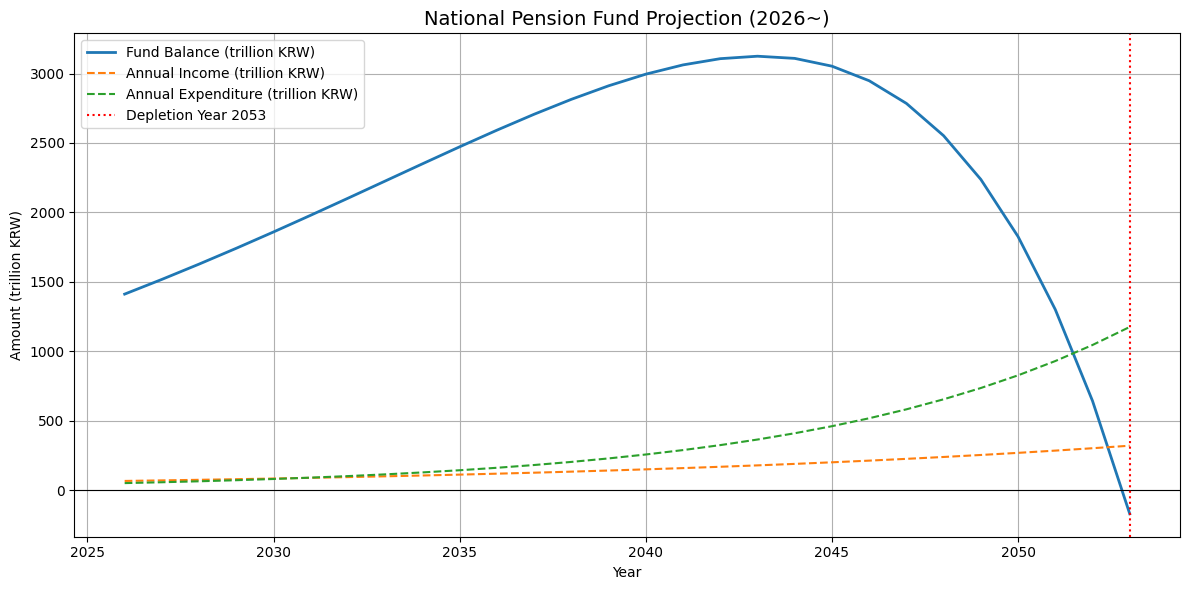

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load and preprocess data
df = pd.read_csv("competition.csv").rename(columns={"Unnamed: 0": "Year"})
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df = df.sort_values("Year")

num_cols = [
    "연금보험료 (단위:억원)", "연금급여지급 (단위:억원)", "관리운영비 등 (단위:억원)",
    "국고보조금 등 (단위:억원)", "연도별 기금 운용 수익률", "국민연금 기금 적립 규모(단위: 조원)"
]
for c in num_cols:
    df[c] = pd.to_numeric(df[c].astype(str).str.replace(",","").str.strip(), errors="coerce")

# 2) Initial values (2024 baseline)
base = df[df["Year"] == 2024].iloc[0]
fund = base["국민연금 기금 적립 규모(단위: 조원)"] * 10000  # convert trillion KRW -> 100 million KRW
contrib = base["연금보험료 (단위:억원)"]
benefit = base["연금급여지급 (단위:억원)"]
admin = base["관리운영비 등 (단위:억원)"]
subsidy = base["국고보조금 등 (단위:억원)"]

# 3) Calculate CAGR and avg return
last10 = df[df["Year"] >= df["Year"].max()-9]

def cagr(series):
    s = series.dropna()
    if len(s) < 2: return 0.0
    a, b, n = s.iloc[0], s.iloc[-1], len(s)-1
    if a <= 0 or b <= 0: return 0.0
    return (b/a)**(1/n) - 1

g_contrib = cagr(last10["연금보험료 (단위:억원)"])
g_benefit = cagr(last10["연금급여지급 (단위:억원)"])
g_admin   = cagr(last10["관리운영비 등 (단위:억원)"])
g_subsidy = cagr(last10["국고보조금 등 (단위:억원)"])
r = (np.prod(1+last10["연도별 기금 운용 수익률"].dropna()/100)**(1/max(1,len(last10.dropna()))) - 1) or 0.04

# 4) Projection (2025 ~ 2100 or until depletion)
rows = []
for year in range(2025, 2101):
    if year > 2025:
        contrib *= (1+g_contrib)
        benefit *= (1+g_benefit)
        admin   *= (1+g_admin)
        subsidy *= (1+g_subsidy)

    invest_income = fund * r
    net_cash = contrib + subsidy - (benefit + admin)
    fund = fund + invest_income + net_cash

    rows.append([year, contrib+subsidy, benefit+admin, invest_income, fund])
    if fund <= 0:
        break

result = pd.DataFrame(rows, columns=["Year","Income","Expenditure","InvestmentReturn","FundBalance"])
result_2026_on = result[result["Year"] >= 2026].copy()

# 5) Plot
plt.figure(figsize=(12,6))
plt.plot(result_2026_on["Year"], result_2026_on["FundBalance"]/10000, label="Fund Balance (trillion KRW)", linewidth=2)
plt.plot(result_2026_on["Year"], result_2026_on["Income"]/10000, label="Annual Income (trillion KRW)", linestyle="--")
plt.plot(result_2026_on["Year"], result_2026_on["Expenditure"]/10000, label="Annual Expenditure (trillion KRW)", linestyle="--")

plt.axhline(0, color="black", linewidth=0.8)
if not result_2026_on[result_2026_on["FundBalance"] <= 0].empty:
    depletion_year = int(result_2026_on.loc[result_2026_on["FundBalance"] <= 0, "Year"].min())
    plt.axvline(depletion_year, color="red", linestyle=":", label=f"Depletion Year {depletion_year}")

plt.title("National Pension Fund Projection (2026~)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Amount (trillion KRW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# 1) Load and preprocess data
df = pd.read_csv("competition.csv").rename(columns={"Unnamed: 0": "Year"})
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df = df.sort_values("Year")

num_cols = [
    "연금보험료 (단위:억원)", "연금급여지급 (단위:억원)", "관리운영비 등 (단위:억원)",
    "국고보조금 등 (단위:억원)", "연도별 기금 운용 수익률", "국민연금 기금 적립 규모(단위: 조원)"
]
for c in num_cols:
    df[c] = pd.to_numeric(df[c].astype(str).str.replace(",","").str.strip(), errors="coerce")

# 2) Initial values (2024 baseline)
base = df[df["Year"] == 2024].iloc[0]
fund = base["국민연금 기금 적립 규모(단위: 조원)"] * 10000  # 조원 -> 억원
contrib = base["연금보험료 (단위:억원)"]
benefit = base["연금급여지급 (단위:억원)"]
admin = base["관리운영비 등 (단위:억원)"]
subsidy = base["국고보조금 등 (단위:억원)"]

# 3) Calculate CAGR and average return
last10 = df[df["Year"] >= df["Year"].max()-9]
def cagr(s):
    s = s.dropna()
    if len(s) < 2: return 0.0
    a, b, n = s.iloc[0], s.iloc[-1], len(s)-1
    if a <= 0 or b <= 0: return 0.0
    return (b/a)**(1/n) - 1

g_contrib = cagr(last10["연금보험료 (단위:억원)"])
g_benefit = cagr(last10["연금급여지급 (단위:억원)"])
g_admin   = cagr(last10["관리운영비 등 (단위:억원)"])
g_subsidy = cagr(last10["국고보조금 등 (단위:억원)"])
r = (np.prod(1+last10["연도별 기금 운용 수익률"].dropna()/100)**(1/max(1,len(last10.dropna()))) - 1) or 0.04

# 4) Projection
rows=[]
for year in range(2025, 2101):
    if year > 2025:
        contrib *= (1+g_contrib)
        benefit *= (1+g_benefit)
        admin   *= (1+g_admin)
        subsidy *= (1+g_subsidy)

    invest_income = fund * r
    net_cash = contrib + subsidy - (benefit + admin)
    fund = fund + invest_income + net_cash

    rows.append([year, int(contrib+subsidy), int(benefit+admin), int(invest_income), int(fund)])
    if fund <= 0:
        break

result = pd.DataFrame(rows, columns=["연도","예상수입(억원)","예상지출(억원)","예상운용수익(억원)","연도말 잔여 기금(억원)"])

# 보기 좋게 출력: 억 단위, 천단위 구분기호
pd.options.display.float_format = '{:,.0f}'.format
print(result.head(10))   # 앞부분
print(result.tail(10))   # 뒷부분

# 고갈 연도 확인
depletion_year = result.loc[result["연도말 잔여 기금(억원)"] <= 0, "연도"].min()
print("예상 고갈 연도:", depletion_year)

     연도  예상수입(억원)  예상지출(억원)  예상운용수익(억원)  연도말 잔여 기금(억원)
0  2025    618835    445384      795637       13098088
1  2026    656193    500219      859208       14113271
2  2027    695807    561859      925802       15173020
3  2028    737812    631153      995319       16274998
4  2029    782353    709052     1067607       17415906
5  2030    829582    796627     1142448       18591310
6  2031    879664    895084     1219552       19795442
7  2032    932768   1005777     1298541       21020974
8  2033    989078   1130229     1378933       22258756
9  2034   1048788   1270155     1460129       23497519
      연도  예상수입(억원)  예상지출(억원)  예상운용수익(억원)  연도말 잔여 기금(억원)
19  2044   1884775   4090780     2049783       31091445
20  2045   1998558   4599165     2039536       30530374
21  2046   2119210   5170853     2002730       29481462
22  2047   2247146   5813731     1933924       27848801
23  2048   2382805   6536671     1826825       25521760
24  2049   2526655   7349649     1674175       22372941
25 